In [2]:
import pandas as pd
import pickle as pkl
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from ast import literal_eval
import seaborn as sns
from scipy import stats

In [3]:
import sys
sys.path.append('/work/magroup/kaileyhu/synthetic_lethality')

In [87]:
with open ("/work/magroup/kaileyhu/res/ablations/cv1/gene2vec_UQ_TISSUE_5_fold_0.1_calib.pkl", "rb") as f: #_tester
    mondrian_uq = pkl.load(f)

with open ("/work/magroup/kaileyhu/res/ablations/cv1/gene2vec_UQ_NONE_5_fold_0.1_calib.pkl", "rb") as f: #_tester
    regular_uq = pkl.load(f)

In [5]:
with open("/work/magroup/kaileyhu/res/UQ/Mondrian_by_tissue_NSM_EXP_5x.pkl", "rb") as f:
    mondrian_class_dict = pkl.load(f)

def extract_name(x):
    return x["patient"]

In [6]:
def get_df(uq):
    test_names = uq['mondrian_test_names']
    patient_names = [list(map(lambda x : x.split(',')[0][1:], list(test_names[i].index))) for i in range(len(test_names))]
    test_names = [test_names[i][['gene 1', 'gene 2']] for i in range(len(test_names))]
    
    corr = uq['mondrian_corr']
    pred_vals = uq['mondrian_pred_vals']
    
    conf_scores = uq['mondrian_conf_scores']
    conf_scores = [item for sublist in conf_scores for item in sublist]
    conf_scores_high = [x[0] for x in conf_scores]
    conf_scores_low = [x[1] for x in conf_scores]
    
    fold_list = [[fold for i in range(len(corr[fold]))] for fold in range(len(corr))]
    
    test_genes_1 = [list(test_names[fold]['gene 1']) for fold in range(len(corr))]
    test_genes_2 = [list(test_names[fold]['gene 2']) for fold in range(len(corr))]
    test_genes_1 = [item for sublist in test_genes_1 for item in sublist]
    test_genes_2 = [item for sublist in test_genes_2 for item in sublist]
    
    corr = [item for sublist in corr for item in sublist]
    pred_vals = [item for sublist in pred_vals for item in sublist]
    fold_list = [item for sublist in fold_list for item in sublist]
    patient_names = [item for sublist in patient_names for item in sublist]
    
    uq_df = pd.DataFrame({'gene 1': test_genes_1, 'gene 2' : test_genes_2, 'label' : corr, 'pred' : pred_vals, 'conf high' : conf_scores_high, 'conf low' : conf_scores_low, 'fold' : fold_list, 'patient' : patient_names})
    uq_df['conf high'] = uq_df['conf high'].apply(lambda x : round(x, 3)) 
    uq_df['conf low'] = uq_df['conf low'].apply(lambda x : round(x, 3)) 
    
    uq_df['correct'] = uq_df.apply(lambda row : row['label'] == row['pred'], axis = 1)

    uq_df['tissue'] = uq_df['patient'].apply(lambda x : mondrian_class_dict[x])
    uq_df['tissue'] = uq_df['tissue'].apply(lambda x : str(x).lower())
    return uq_df

In [97]:
mond_df = get_df(mondrian_uq)
reg_df = get_df(regular_uq)

In [98]:
metadata = pd.read_csv("/work/magroup/kaileyhu/datasets/depmap/metadata.csv")
metadata.set_index("ModelID", inplace = True)

In [99]:
tissues = [str(t).lower() for (t, v) in Counter(metadata['SampleCollectionSite']).items() if v > 10 and str(t) != 'nan' and str(t) != 'unknown']

In [100]:
mond_tissues = {}
reg_tissues = {}

mond_acc = {}
reg_acc = {}

for t in tqdm(tissues):
    mond_t = mond_df[mond_df['label'] == 1]
    mond_t = mond_t[mond_t['tissue'] == t]

    reg_t = reg_df[reg_df['label'] == 1]
    reg_t = reg_t[reg_t['tissue'] == t]
    
    mond_t_best = mond_t[mond_t['conf high'] > 0.95]
    reg_t_best = reg_t[reg_t['conf high']  > 0.95]
    if len(mond_t) == 0 or len(reg_t) == 0: 
        continue
    mond_tissues[t] = len(mond_t_best) / len(mond_t)
    reg_tissues[t] = len(reg_t_best) / len(reg_t)

    mond_t = mond_t[mond_t['correct']]
    reg_t = reg_t[reg_t['correct']]
    mond_acc[t] = len(mond_t)
    reg_acc[t] = len(reg_t)

100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


In [ ]:
max(dict(Counter(mond_df['conf high'])).keys())

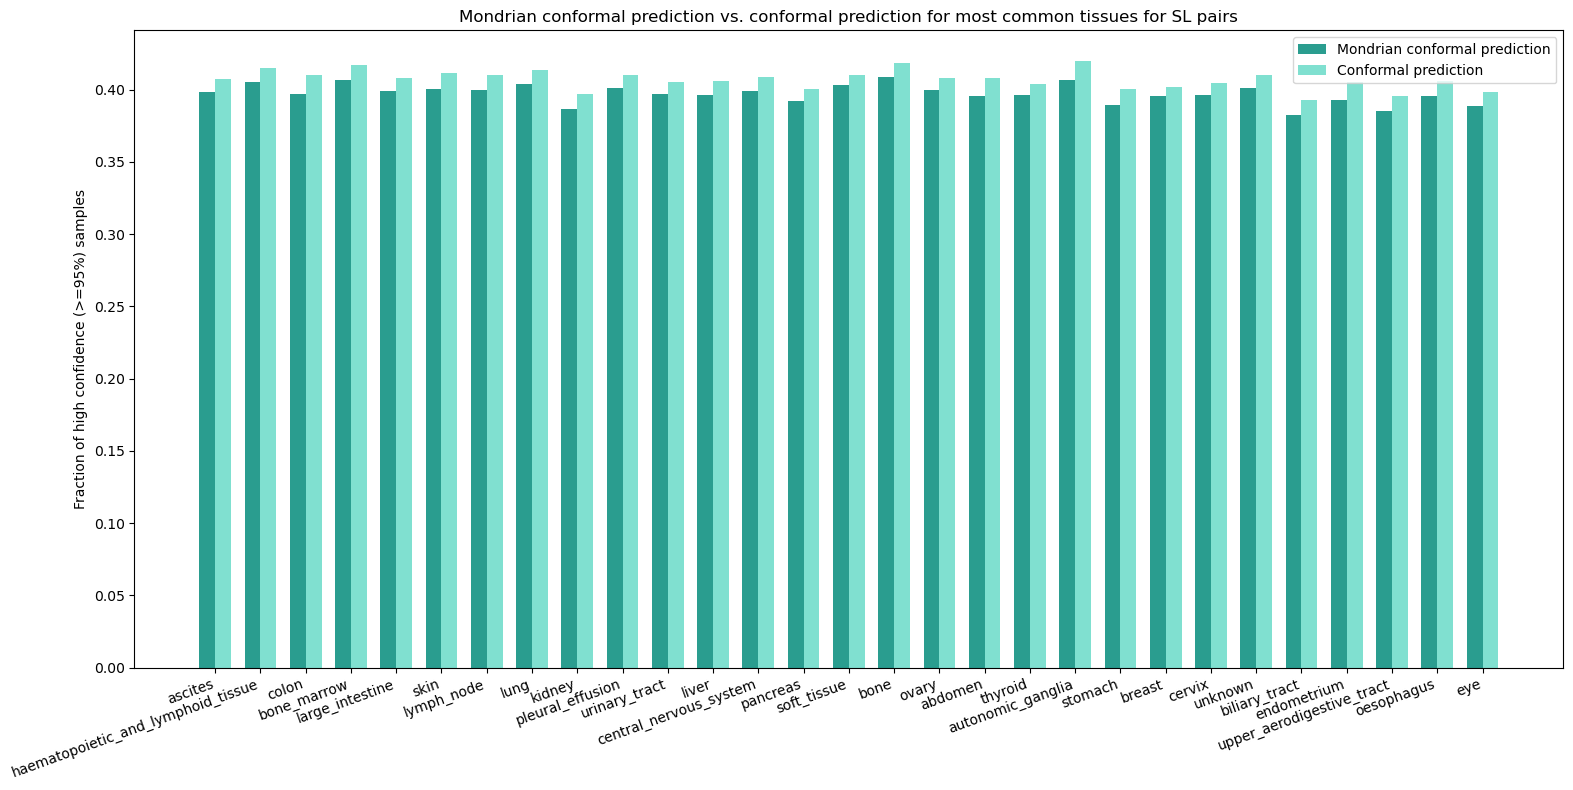

In [11]:
tissues2 = list(mond_tissues.keys())

n = len(tissues2)
ind = np.arange(n) # The x locations for the groups
width = 0.35      # The width of the bars

# 3. Create the plot
plt.figure(figsize=(16, 8))


mond_values = [mond_tissues[t] for t in tissues2]
reg_values = [reg_tissues[t] for t in tissues2]

# Plot the bars side by side
plt.bar(ind - width/2, mond_values, width, label='Mondrian conformal prediction', color = "#2A9D8F")
plt.bar(ind + width/2, reg_values, width, label='Conformal prediction', color = "#80E0D0")

# 4. Add labels and title
plt.ylabel('Fraction of high confidence (>=95%) samples')
plt.title('Mondrian conformal prediction vs. conformal prediction for most common tissues for SL pairs')

plt.xticks(ind, tissues2, rotation=20, ha='right') # Rotate labels for readability
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from being cut off

# 5. Save the plot
plt.savefig('mondrian_vs_conformal.png')

In [12]:
def plot_coverage(mond_df, reg_df, title):
    plt.figure(figsize=(8, 6))
    
    alphas = np.linspace(0.00, 0.5, 100)
    target_confidence = 1 - alphas
    
    # Calculate empirical coverage for each alpha
    coverage_rates = []
    for alpha in alphas:
        is_covered = mond_df['conf high'] >= alpha
        empirical_coverage = is_covered.mean()
        coverage_rates.append(empirical_coverage)
    
    plt.plot(target_confidence, coverage_rates, label='Mondrian conformal prediction', linestyle='-', color="#2A9D8F", linewidth = 2) 

    coverage_rates = []
    for alpha in alphas:
        is_covered = reg_df['conf high'] >= alpha
        empirical_coverage = is_covered.mean()
        coverage_rates.append(empirical_coverage)
    
    plt.plot(target_confidence, coverage_rates, label='Conformal prediction', linestyle='-', color="#80E0D0", linewidth = 2) 
    
    plt.plot([0.5, 1.0], [0.5, 1.0], '--', label='y = x', color="#E76F51", linewidth = 2) 
    
    plt.xlabel('Expected coverage', fontsize=14)
    plt.ylabel('Empirical coverage', fontsize=14)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    # plt.show()
    plt.savefig("coverage.png")

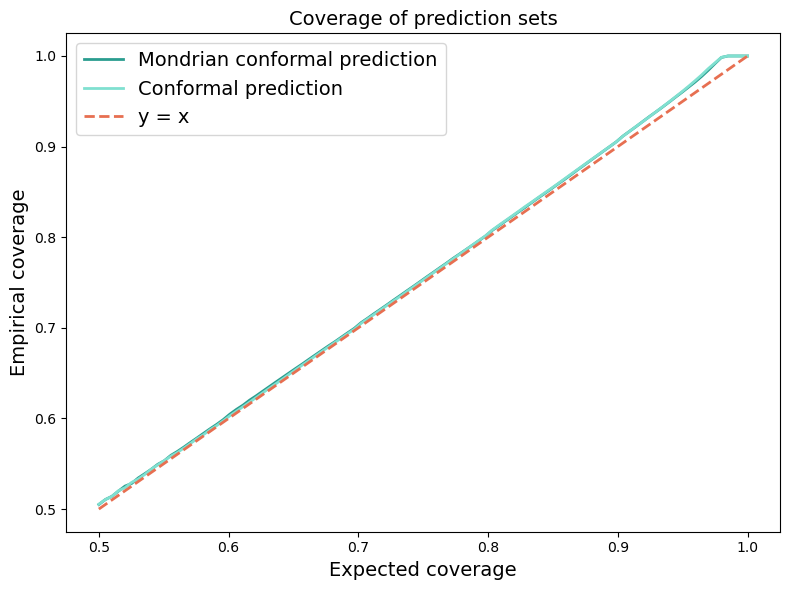

In [13]:
plot_coverage(mond_df, reg_df, "Coverage of prediction sets")

In [420]:
category_order = tissues2

/tmp/ipykernel_429316/3719410336.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


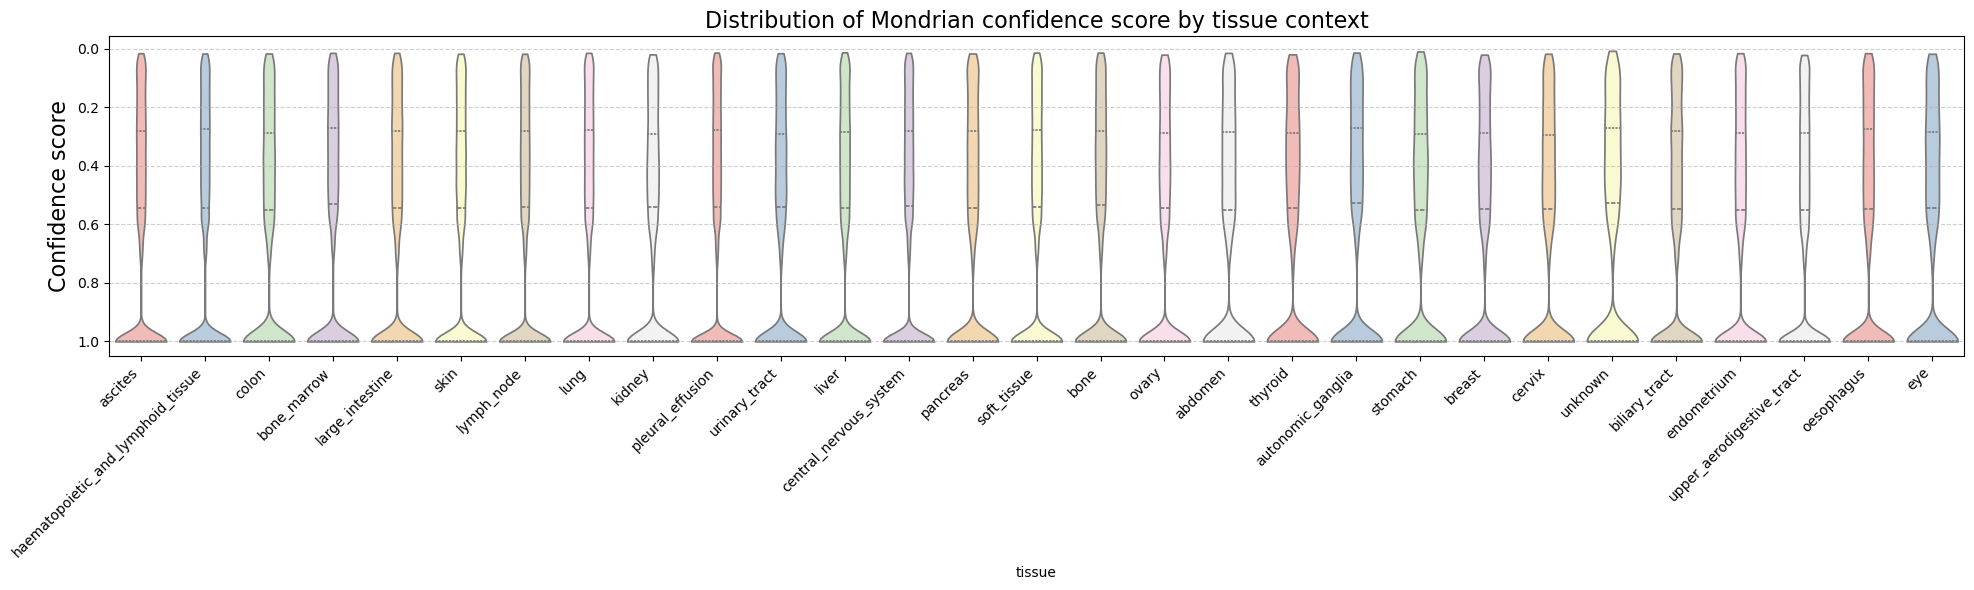

In [463]:
plt.figure(figsize=(20, 6))
sns.violinplot(
    x='tissue', # Change to 'Tissue' to group by tissue instead
    y='conf high',
    data=mond_df,
    palette='Pastel1',
    inner='quartile', # Shows median and quartiles
    cut=0,
    order=category_order
)

plt.ylabel('Confidence score', fontsize=16)
plt.title('Distribution of Mondrian confidence score by tissue context', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis() 
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.savefig('mondrian_violin.png')

In [ ]:
plt.figure(figsize=(20, 6))
sns.violinplot(
    x='tissue', # Change to 'Tissue' to group by tissue instead
    y='conf high',
    data=reg_df,
    palette='Pastel1',
    inner='quartile', # Shows median and quartiles
    cut=0,
    order=category_order
)

plt.ylabel('Confidence score', fontsize=16)
plt.title('Distribution of confidence score by tissue context', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis() 
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.savefig('regular_violin.png')

In [107]:
def plot_singleton_rate(data, title, alpha, path):
    data = data[alpha]
    df = pd.DataFrame(data).T
    df.columns = df.columns.astype(str) # Convert column names to strings for easier use
    
    # Data preparation for plotting
    categories = df.index
    bar_labels = df.columns
    num_categories = len(categories)
    num_bars = len(bar_labels)
    bar_width = 0.2
    spacing = 0.05 # Spacing between bars in a group
    group_width = num_bars * bar_width + (num_bars - 1) * spacing
    # Base positions for the groups, creating a gap between groups
    index = np.arange(num_categories) * (group_width + bar_width) 
    
    # Plotting
    fig, ax = plt.subplots(figsize=(16, 8)) 
    # ax.set_ylim(0.9, 1.0) 

    colors = ["#264653", "#2A9D8F"]
    
    for i, col in enumerate(df.columns):
        # Calculate the position for each bar within a group
        position = index + i * (bar_width + spacing)
        ax.bar(position, df[col], bar_width, label=col, color=colors[i])
    
    # Customize plot
    ax.set_ylabel('Fraction of samples with prediction set size 1', fontsize=16)
    ax.set_title(title, fontsize=16)
    
    # Set the x-axis ticks to be in the center of the groups
    # This centers the label under the entire group of bars
    ax.set_xticks(index + group_width / 2 - bar_width/2 - spacing/2)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    
    # Add a legend outside the plot area
    ax.legend(title='Uncertainty quantification', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(path)

In [15]:
tissue_alpha_dict = {}
tissue_corr_dict = {}

In [27]:
def extract_name(x):
    return (x["patient"], x["gene 1"], x["gene 2"])

with open("/work/magroup/kaileyhu/res/UQ/Mondrian_by_hotspot.pkl", "rb") as f:
    hotspot_class_dict = pkl.load(f)

In [28]:
mond_df['hotspot'] = mond_df.apply(lambda x : hotspot_class_dict[extract_name(x)], axis = 1)

In [33]:
reg_df['hotspot'] = reg_df.apply(lambda x : hotspot_class_dict[extract_name(x)], axis = 1)

In [139]:
for a in [0.05, 0.1, 0.2, 0.4]:
    # alpha = 1 - a
    alpha = a
    tissue_mond_dict = {}
    temp_dict = {}
    for t in tqdm(tissues2):
        # Mondrian (stratified) p-values
        tissue_df = mond_df[(mond_df['tissue'] == t)] # & (mond_df['label'] == 1)]
        if len(tissue_df) == 0:
            mond_singleton = np.nan
        else:
            is_singleton = (tissue_df['conf high'] > alpha) & (tissue_df['conf low'] <= alpha)
            temp_df = tissue_df[(tissue_df['conf high'] > alpha) & (tissue_df['conf low'] <= alpha)]
            mond_corr = temp_df['correct'].mean()
            mond_singleton = is_singleton.mean()

        # Regular (non-Mondrian) p-values
        tissue_df2 = reg_df[(reg_df['tissue'] == t)] # & (reg_df['label'] == 1)]
        if len(tissue_df2) == 0:
            reg_singleton = np.nan
        else:
            is_singleton2 = (tissue_df2['conf high'] > alpha) & (tissue_df2['conf low'] <= alpha)
            temp_df = tissue_df2[(tissue_df2['conf high'] > alpha) & (tissue_df2['conf low'] <= alpha)]
            reg_corr = temp_df['correct'].mean()
            reg_singleton = is_singleton2.mean()

        tissue_mond_dict[t] = {
            "Mondrian conformal prediction": mond_singleton,
            "Conformal prediction": reg_singleton,
        }
        temp_dict[t] = {
            "Mondrian conformal prediction": mond_corr,
            "Conformal prediction": reg_corr,
        }
        
    tissue_corr_dict[alpha] = temp_dict
    tissue_alpha_dict[alpha] = tissue_mond_dict

100%|██████████| 29/29 [00:13<00:00,  2.13it/s]


In [141]:
alpha = 0.05

df_singleton = pd.DataFrame.from_dict(tissue_alpha_dict[alpha], orient='index')
df_singleton.index.name = 'Tissue'
df_singleton.columns = ['Mondrian conformal prediction', 'Conformal prediction']

t_statistic, p_value = stats.ttest_rel(
    df_singleton['Mondrian conformal prediction'],
    df_singleton['Conformal prediction']
)

print(f"Paired T-Test results for alpha = {alpha}:")
print(f"  T-Statistic: {t_statistic}")
print(f"  P-Value: {p_value}")

# To inspect the difference
mean_mondrian = df_singleton['Mondrian conformal prediction'].mean()
mean_regular = df_singleton['Conformal prediction'].mean()
print(f"Mean difference (Mondrian conformal prediction - conformal prediction): {mean_mondrian - mean_regular}")

Paired T-Test results for alpha = 0.05:
  T-Statistic: -0.17301902966702912
  P-Value: 0.8638811470527019
Mean difference (Mondrian conformal prediction - conformal prediction): -0.00016620349854667982


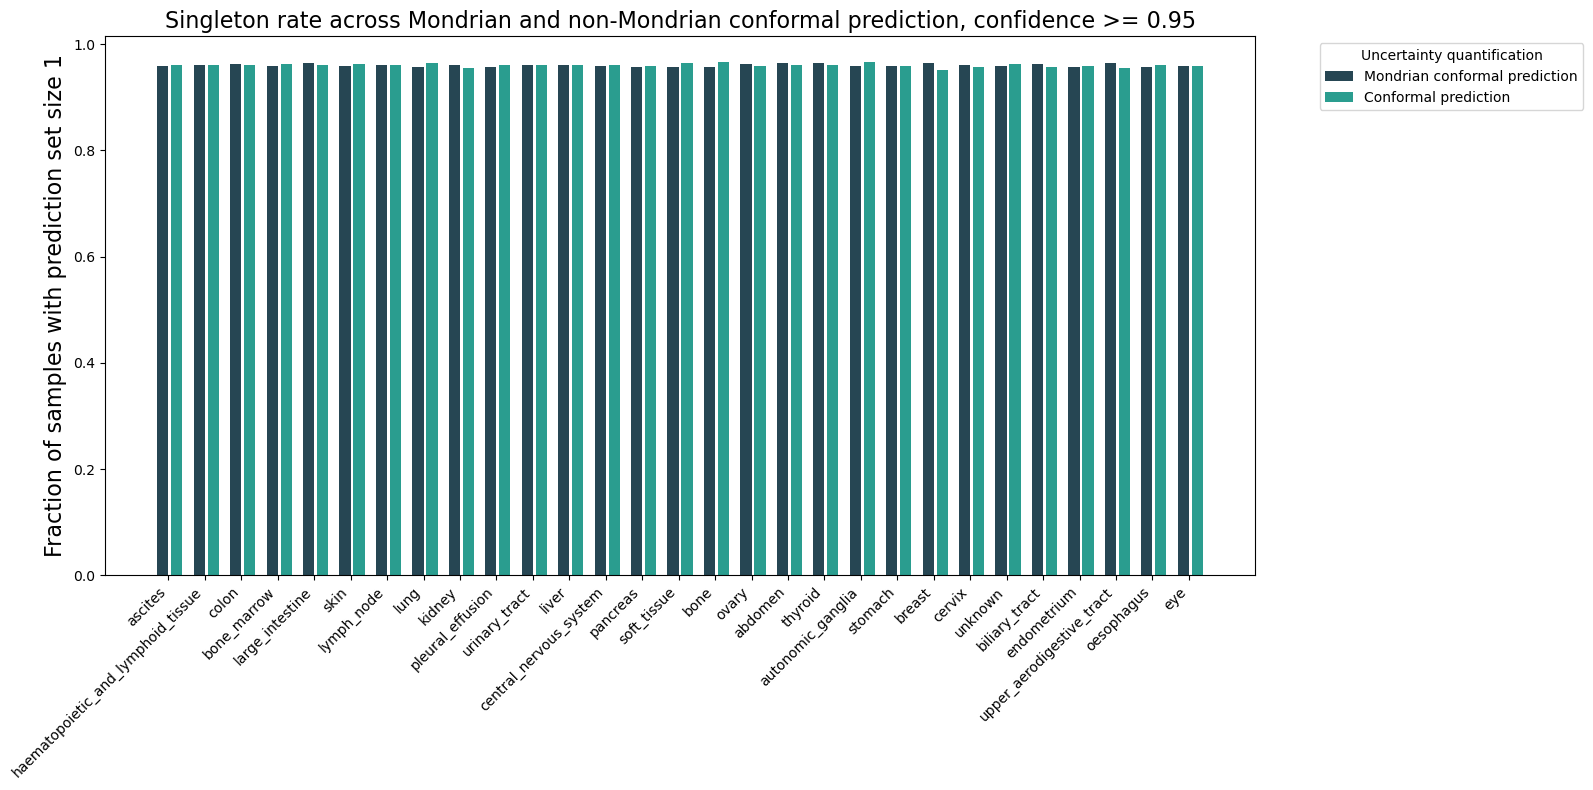

In [142]:
plot_singleton_rate(tissue_alpha_dict, f'Singleton rate across Mondrian and non-Mondrian conformal prediction, confidence >= {1 - alpha}', alpha, f"singleton_{alpha}.png")

In [49]:
alpha = 0.4

df_singleton = pd.DataFrame.from_dict(hotspot_corr_dict[alpha], orient='index')
df_singleton.index.name = 'Hotspot'
df_singleton.columns = ['Mondrian conformal prediction', 'Conformal prediction']

t_statistic, p_value = stats.ttest_rel(
    df_singleton['Mondrian conformal prediction'],
    df_singleton['Conformal prediction']
)

print(f"Paired T-Test results for alpha = {alpha}:")
print(f"  T-Statistic: {t_statistic}")
print(f"  P-Value: {p_value}")

# To inspect the difference
mean_mondrian = df_singleton['Mondrian conformal prediction'].mean()
mean_regular = df_singleton['Conformal prediction'].mean()
print(f"Mean difference (Mondrian conformal prediction - conformal prediction): {mean_mondrian - mean_regular}")

Paired T-Test results for alpha = 0.4:
  T-Statistic: -0.041360302332566934
  P-Value: 0.9707663493923906
Mean difference (Mondrian conformal prediction - conformal prediction): -0.0023692310777059244


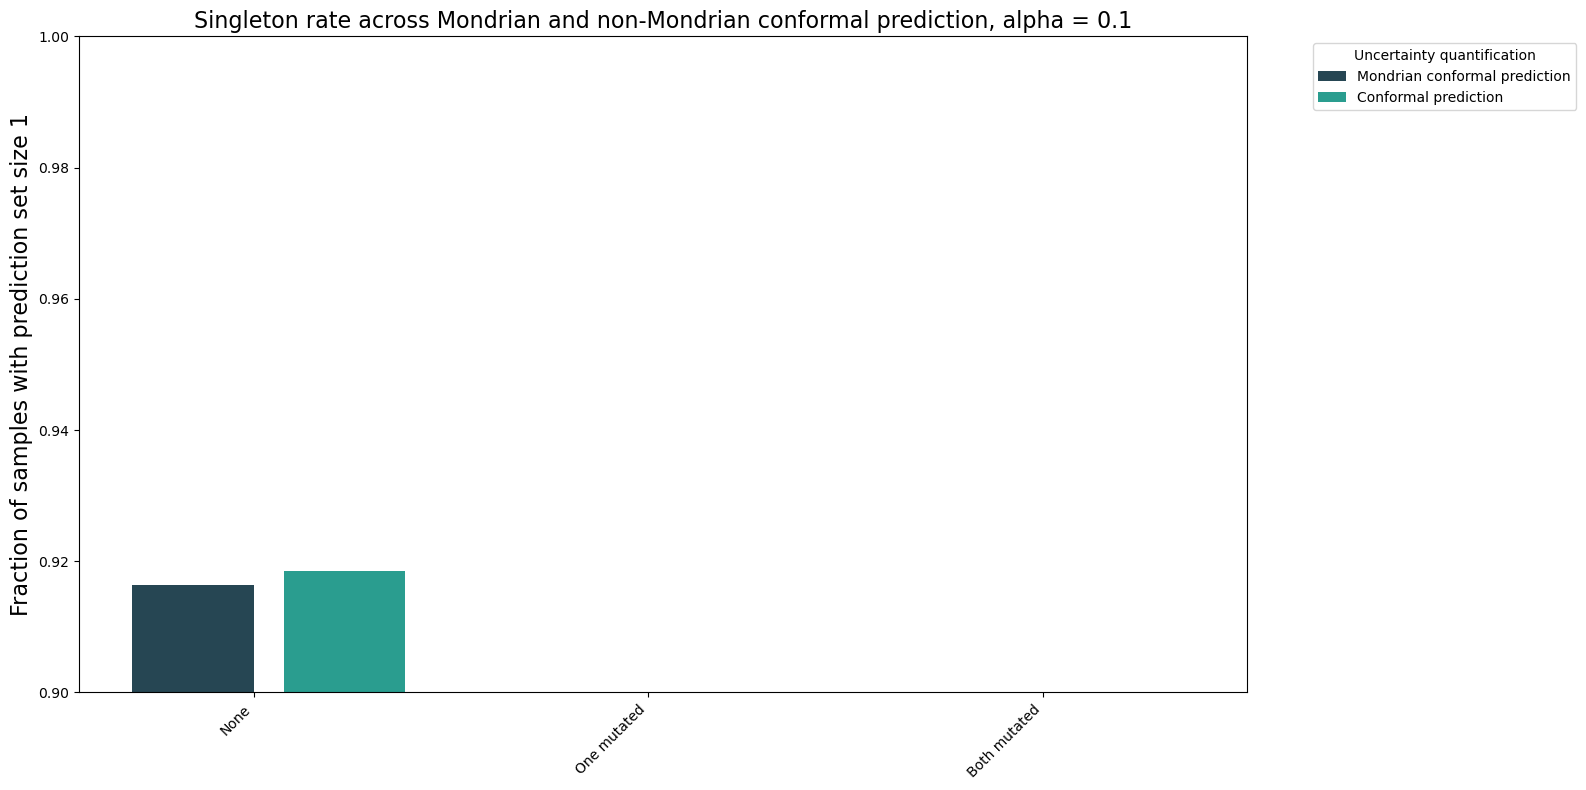

In [47]:
plot_singleton_rate(hotspot_corr_dict, f'Singleton rate across Mondrian and non-Mondrian conformal prediction, alpha = {alpha}', alpha, f"singleton_{alpha}.png")

In [154]:
tissue_alpha_dict = {}
for t in tqdm(tissues2):
    temp = {}
    for alpha in [0.05, 0.1, 0.2]:
        tissue_df = reg_df[reg_df['label'] == 1]
        tissue_df = tissue_df[tissue_df['tissue'] == t]
        singletons = tissue_df[tissue_df['conf'] >= 1 - alpha]
        num_s = len(singletons) / len(tissue_df)
        temp[alpha] = num_s
    tissue_alpha_dict[t] = temp

100%|██████████| 29/29 [00:24<00:00,  1.20it/s]


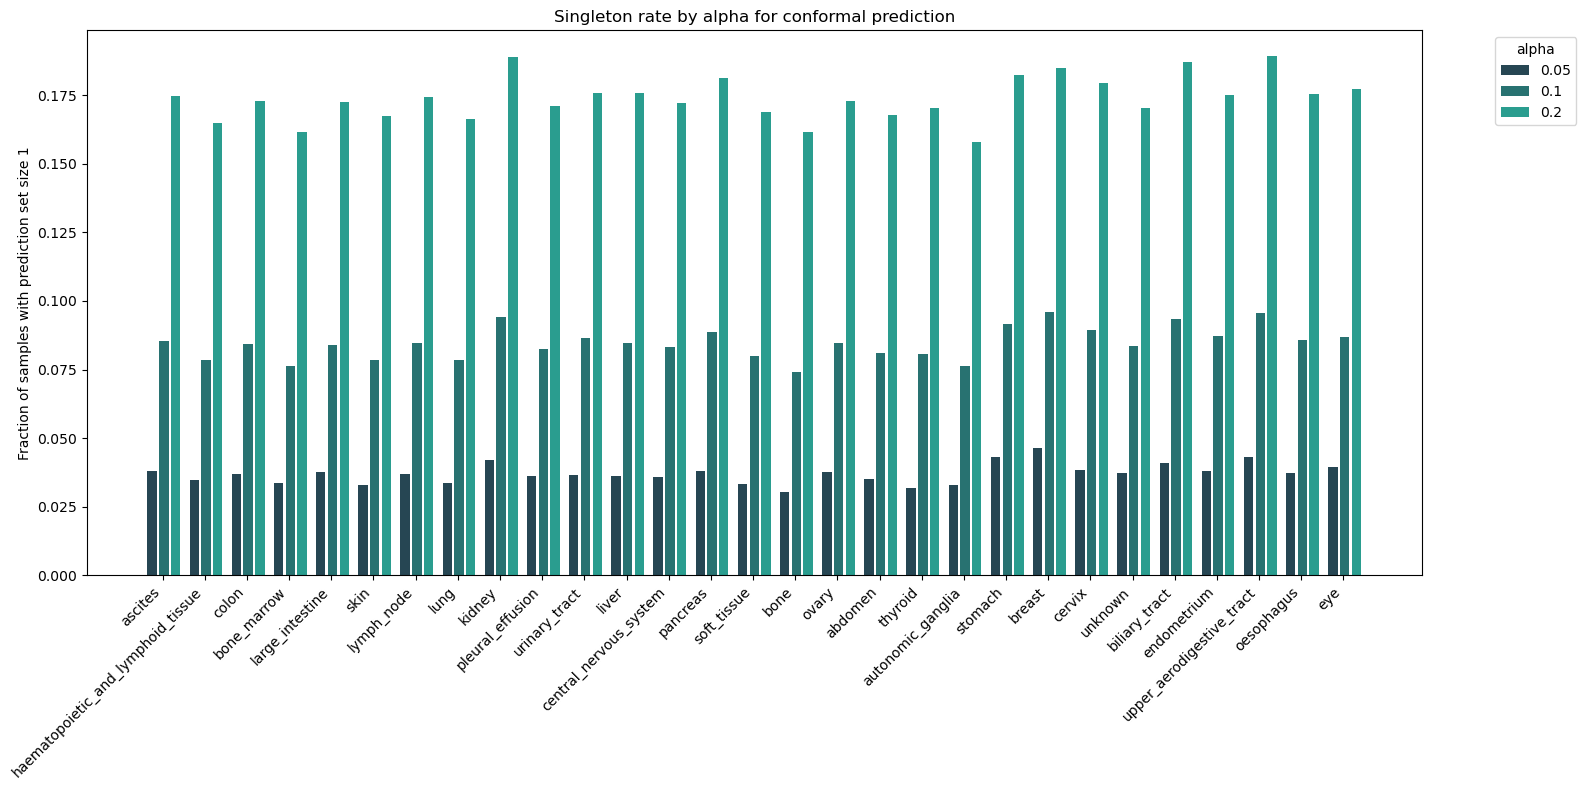

In [155]:
plot_singleton_rate(tissue_alpha_dict, 'Singleton rate by alpha for conformal prediction')

In [473]:
mond_df['gene_pairs'] = mond_df.apply(lambda row : (row['gene 1'], row['gene 2']), axis = 1)

In [476]:
import random

In [482]:
mond_df

,gene 1,gene 2,label,pred,conf high,conf low,fold,patient,correct,tissue,gene_pairs
0,CIDEA,NAE1,0,1,1.000,0.001,0,ACH-000486,False,urinary_tract,"(CIDEA, NAE1)"
1,CIDEA,NAE1,0,1,1.000,0.000,0,ACH-001370,False,ovary,"(CIDEA, NAE1)"
2,CIDEA,NAE1,0,1,1.000,0.000,0,ACH-000434,False,central_nervous_system,"(CIDEA, NAE1)"
3,PSMA4,KRAS,0,1,0.055,0.007,0,ACH-000754,False,pleural_effusion,"(PSMA4, KRAS)"
4,PSMA4,KRAS,0,1,0.026,0.007,0,ACH-000114,False,liver,"(PSMA4, KRAS)"
...,...,...,...,...,...,...,...,...,...,...,...
4950096,MTF2,MYOF,0,0,0.221,0.003,4,ACH-000646,True,ovary,"(MTF2, MYOF)"
4950097,MTF2,MYOF,0,0,0.220,0.004,4,ACH-000141,True,biliary_tract,"(MTF2, MYOF)"
4950098,EML1,RPS6KA1,0,0,0.152,0.003,4,ACH-001685,True,pleural_effusion,"(EML1, RPS6KA1)"
4950099,EML1,RPS6KA1,0,0,0.151,0.003,4,ACH-000702,True,haematopoietic_and_lymphoid_tissue,"(EML1, RPS6KA1)"


In [484]:
best_alpha = {}
for t in tissues2:
    temp = mond_df[(mond_df['tissue'] == t) & (mond_df['pred'] == 1)]
    sorted_list = temp['gene_pairs'].tolist()
    random.shuffle(sorted_list)
    sorted_list = sorted(sorted_list, reverse=True)
    unique_list = list(dict.fromkeys(sorted_list))
    best_alpha[t] = unique_list[:10]

In [ ]:
# do the confidence plot by source
# send crispr ones

In [56]:
SL_df = pd.read_csv("/work/magroup/kaileyhu/datasets/SynLethDB/Human_SL.csv")
nonSL_df = pd.read_csv("/work/magroup/kaileyhu/datasets/SynLethDB/Human_nonSL.csv")



In [58]:
SL_df['gene_pairs'] = SL_df.apply(lambda row : (row['n1.name'], row['n2.name']), axis = 1)
nonSL_df['gene_pairs'] = nonSL_df.apply(lambda row : (row['n1.name'], row['n2.name']), axis = 1)

In [59]:
pair_to_source = SL_df.set_index('gene_pairs')['r.source'].to_dict()
pair_to_source = pair_to_source | nonSL_df.set_index('gene_pairs')['r.source'].to_dict()

In [60]:
def query_dict(x):
    if x in pair_to_source:
        return pair_to_source[x]
    x_rev = (x[1], x[0])
    if x_rev in pair_to_source:
        return pair_to_source[x_rev]
    else:
        return 'Negative sampling'

In [112]:
reg_df['gene_pairs'] = reg_df.apply(lambda row : (row['gene 1'], row['gene 2']), axis = 1)
reg_df['source'] = reg_df['gene_pairs'].apply(query_dict)

In [65]:
sources = reg_df['source'].unique()
sources

array(['Text Mining', 'RNAi Screen', 'GenomeRNAi', 'High Throughput',
       'CRISPR/CRISPRi', 'Computational Prediction', 'Decipher',
       'Synlethality', 'Low Throughput', 'Drug Screen',
       'GenomeRNAi;Text Mining', 'Decipher;Text Mining',
       'Negative sampling', 'Synlethality;Decipher',
       'Synlethality;Text Mining', 'Text Mining;Synlethality'],
      dtype=object)

In [116]:
alph_dict = {}
for alpha in [0.05, 0.4, 1.0]:
    temp_dict = {}
    for s in tqdm(sources):
        if s == 'Negative sampling':
            continue
        temp_df = reg_df[(reg_df['source'] == s)]
        temp_df = temp_df[(temp_df['conf high'] > 1 - alpha)]
        corr = temp_df['correct'].mean()

        temp_dict[s] = corr
        
    alph_dict[alpha] = temp_dict

100%|██████████| 16/16 [00:03<00:00,  4.62it/s]


In [117]:
df

,0.05,0.4,1.0
Text Mining,0.999133,0.999068,0.998089
RNAi Screen,1.000000,1.000000,1.000000
GenomeRNAi,0.999313,0.999381,0.999149
High Throughput,0.999227,0.999302,0.999093
CRISPR/CRISPRi,0.999829,0.999718,0.999799
Computational Prediction,0.997774,0.997646,0.999114
Decipher,0.999913,0.999922,0.999861
Synlethality,1.000000,1.000000,0.998158
Low Throughput,1.000000,1.000000,1.000000
Drug Screen,0.995559,0.989721,0.998155


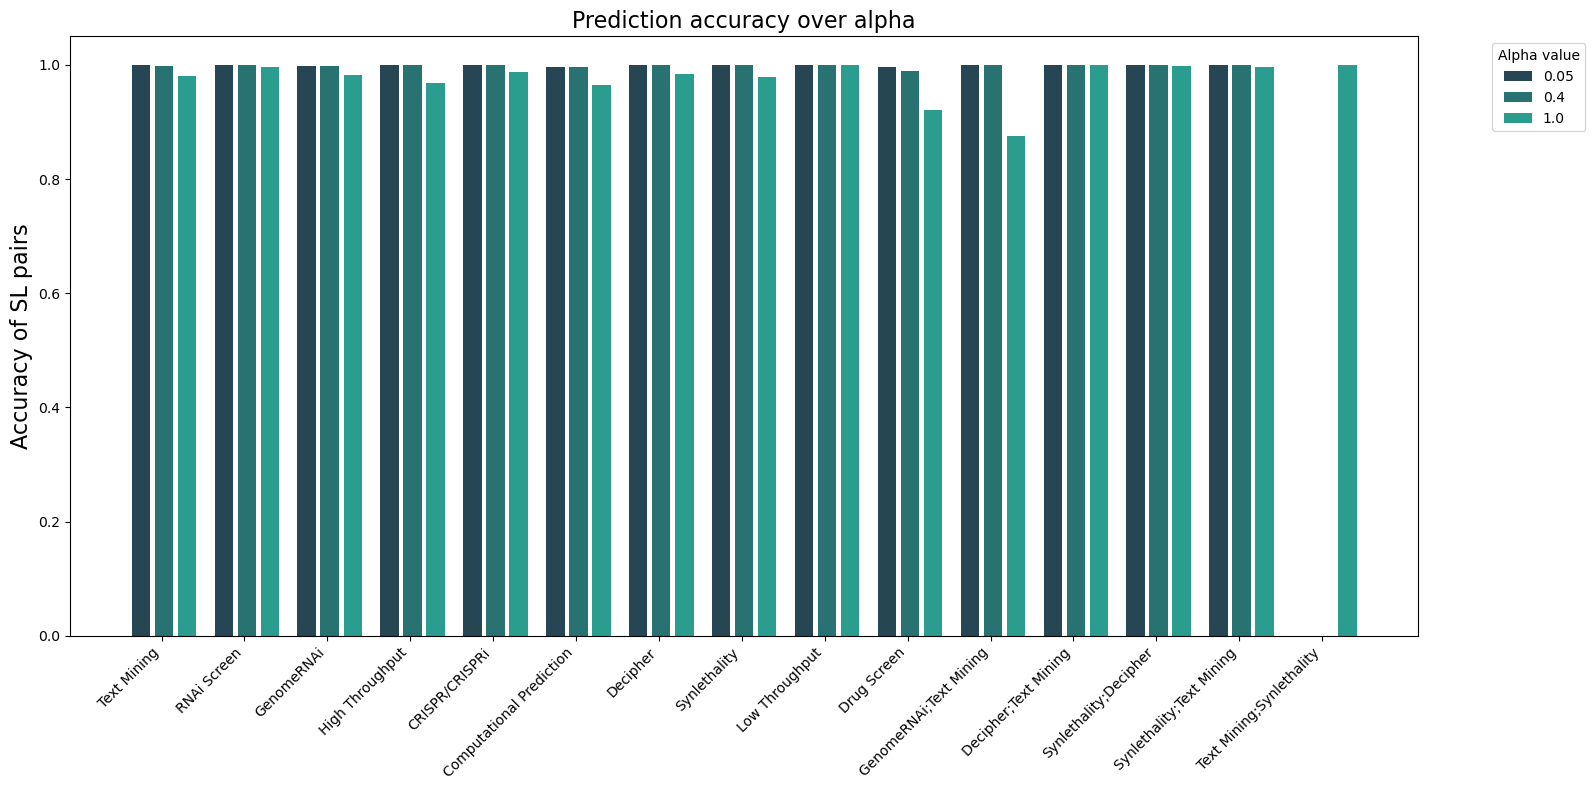

In [118]:
df = pd.DataFrame(alph_dict)
df.columns = df.columns.astype(str) # Convert column names to strings for easier use

# Data preparation for plotting
categories = df.index
bar_labels = df.columns
num_categories = len(categories)
num_bars = len(bar_labels)
bar_width = 0.2
spacing = 0.05 # Spacing between bars in a group
group_width = num_bars * bar_width + (num_bars - 1) * spacing
# Base positions for the groups, creating a gap between groups
index = np.arange(num_categories) * (group_width + bar_width) 

# Plotting
fig, ax = plt.subplots(figsize=(16, 8)) 

colors = ["#264653", "#287271", "#2A9D8F",]

for i, col in enumerate(df.columns):
    # Calculate the position for each bar within a group
    position = index + i * (bar_width + spacing)
    ax.bar(position, df[col], bar_width, label=col, color=colors[i])

# Customize plot
ax.set_ylabel('Accuracy of SL pairs', fontsize=16)
ax.set_title("Prediction accuracy over alpha", fontsize=16)

# Set the x-axis ticks to be in the center of the groups
# This centers the label under the entire group of bars
ax.set_xticks(index + group_width / 2 - bar_width/2 - spacing/2)
ax.set_xticklabels(categories, rotation=45, ha='right')

# Add a legend outside the plot area
ax.legend(title='Alpha value', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
# plt.savefig(path)

In [120]:
CRISPR = reg_df[reg_df['source'] == "CRISPR/CRISPRi"]

In [121]:
temp = CRISPR.sort_values(by='conf high',ascending=False)
top_15_genes = {}
for i in range(len(temp)):
    row = temp.iloc[i]
    g1, g2 = row['gene 1'], row ['gene 2']
    if (g1, g2) not in top_15_genes:
        top_15_genes[(g1, g2)] = row['conf high']
    if len(top_15_genes) == 15:
        break
top_15_genes

{('CEP63', 'MASTL'): 1.0,
 ('EXOSC6', 'PSMD1'): 1.0,
 ('NCBP1', 'TRMT5'): 1.0,
 ('DAP3', 'KCTD10'): 1.0,
 ('EXOSC6', 'TTC4'): 1.0,
 ('DAP3', 'MAPKAP1'): 1.0,
 ('GTF2H4', 'NOL9'): 1.0,
 ('DAP3', 'SNRPD3'): 1.0,
 ('GTF2H4', 'MRPL42'): 1.0,
 ('KIF11', 'PSMD1'): 1.0,
 ('GNPAT', 'NOL10'): 1.0,
 ('GNPAT', 'PNN'): 1.0,
 ('GNPAT', 'GTF2H4'): 1.0,
 ('MED10', 'PSMD4'): 1.0,
 ('MED10', 'ZNF574'): 1.0}

In [133]:
reg_df

,gene 1,gene 2,label,pred,conf high,conf low,fold,patient,correct,tissue,gene_pairs,source
0,CUX1,PARP1,0,1,0.292,0.001,0,ACH-000271,False,pleural_effusion,"(CUX1, PARP1)",Text Mining
1,CUX1,PARP1,0,1,0.023,0.013,0,ACH-000365,False,pleural_effusion,"(CUX1, PARP1)",Text Mining
2,KRAS,AKT2,0,0,0.227,0.002,0,ACH-000754,True,pleural_effusion,"(KRAS, AKT2)",RNAi Screen
3,KRAS,AKT2,0,0,0.335,0.001,0,ACH-000114,True,liver,"(KRAS, AKT2)",RNAi Screen
4,KRAS,AKT2,0,0,0.192,0.002,0,ACH-001001,True,bone,"(KRAS, AKT2)",RNAi Screen
...,...,...,...,...,...,...,...,...,...,...,...,...
4950103,MFNG,PLOD1,0,0,0.057,0.008,4,ACH-000371,True,ascites,"(MFNG, PLOD1)",Negative sampling
4950104,MFNG,PLOD1,0,0,0.059,0.008,4,ACH-000004,True,haematopoietic_and_lymphoid_tissue,"(MFNG, PLOD1)",Negative sampling
4950105,MFNG,PLOD1,0,0,0.129,0.005,4,ACH-000195,True,haematopoietic_and_lymphoid_tissue,"(MFNG, PLOD1)",Negative sampling
4950106,MFNG,PLOD1,0,0,0.043,0.010,4,ACH-000045,True,haematopoietic_and_lymphoid_tissue,"(MFNG, PLOD1)",Negative sampling
